In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

file_path = "F:\\Python\\PPG\\All data\\Patient_Signal\\PPG.csv"
data = pd.read_csv(file_path, header=None)

data.columns = ['Name', 'i', 'Bad', 'hands', 'label', 'systolic peak', 'Diastolic peak', 'Cardiac cycle', 'Cycle Area', 'SSI', 'Peak to Valley', 'Systolic peak y', 'Delta_T', '1st Derivative cycle', '1st Derivative peak', 'Ratio_BA', 'Ratio_CA', 'Ratio_DA', 'Ratio_BDCE_A', 'Ratio_CDB_A']
# Display the first few rows of the dataframe to understand its structure
data.head()

,Name,i,Bad,hands,label,systolic peak,Diastolic peak,Cardiac cycle,Cycle Area,SSI,Peak to Valley,Systolic peak y,Delta_T,1st Derivative cycle,1st Derivative peak,Ratio_BA,Ratio_CA,Ratio_DA,Ratio_BDCE_A,Ratio_CDB_A
0,伍黃秀霞,91,Right,Right,1,1260.0,0.016310,979.0,325.875564,1012.0,738.0,0.956621,-1259.983690,985.0,0.824508,0.162618,0.194410,-0.232789,0.247480,0.008105
1,伍黃秀霞,85,Right,Right,1,1434.0,0.060105,996.0,366.024868,1005.0,563.0,0.343197,-1433.939895,999.0,0.738337,-0.121067,0.113849,0.022481,-0.315197,0.078531
2,伍黃秀霞,87,Right,Right,1,1436.0,0.358166,993.0,406.070910,994.0,561.0,0.389378,-1435.641834,991.0,0.920492,-0.080791,0.139465,-0.057912,-0.220992,0.022904
3,伍黃秀霞,89,Right,Right,1,1431.0,0.153496,1005.0,377.368646,1132.0,567.0,0.573135,-1430.846504,1004.0,0.750703,0.015843,0.279647,0.015371,-0.323899,0.250292
4,劉正國,7,Left,Right,1,1498.0,-0.042892,1258.0,428.350856,1282.0,-238.0,0.801594,-1498.042892,1255.0,0.905265,0.124731,0.159378,-0.187370,0.287386,0.106671


In [52]:
info_columns = data[['Name', 'i', 'Bad', 'hands']]
X = data.iloc[:, 5:]  # 特徵列
y = data['label']     # 標籤
#印出x的標題
print(X.columns[0])

# 分割訓練和測試集
X_train, X_test, y_train, y_test, info_train, info_test = train_test_split(X, y, info_columns, test_size=0.3, random_state=42)

# 特徵標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

systolic peak


In [53]:
# 繪製混淆矩陣
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    plt.figure(figsize=(5, 5), dpi=120)
    plt.imshow(conf_matrix, cmap='summer')
    plt.colorbar()

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, str(conf_matrix[i, j]), fontsize=12,
                     horizontalalignment='center', verticalalignment='center')


    
    plt.xticks(np.arange(0, 2), ['Predicted 0', 'Predicted 1'])
    plt.yticks(np.arange(0, 2), ['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

In [54]:
# 計算性能指標
def calculate_metrics(conf_matrix):
    tp = conf_matrix[0, 0]
    fn = conf_matrix[0, 1]
    fp = conf_matrix[1, 0]
    tn = conf_matrix[1, 1]
    accuracy = (tp + tn) / (tp + fn + fp + tn) if (tp + fn + fp + tn) != 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0

    metrics = {
        "Accuracy": round(accuracy,3),
        "Sensitivity (Recall)": round(sensitivity,3),
        "Specificity": round(specificity,3),
        "Precision": round(precision,3),
        "F1-Score": round(f1_score,3)
    }
    return metrics

In [55]:
# 儲存結果到 CSV
def save_results_to_csv(filename, info, y_test, y_pred):
    new_data = pd.DataFrame({
        'Name': info['Name'].values,
        'Cycle': info['i'].values,
        'Hands': info['hands'].values,
        'Actual_Label': y_test.values,
        'Predicted_Label': y_pred
    })

    new_data = new_data.sort_values(by='Name')
    new_data['Is_Correct'] = new_data['Actual_Label'] == new_data['Predicted_Label']
    new_data.to_csv(f"F:\\Python\\PPG\\All data\\Patient_Signal\\Classfication\\{filename}.csv", index=False, encoding='utf-8-sig')
    print(f"Results saved to {filename}.csv")

    # 將最終的 Actual_Label 和 Predicted_Label 的總結結果保存
    final_summary = new_data.groupby('Name').agg(
    Actual_0_Count=('Actual_Label', lambda x: (x == 0).sum()),
    Actual_1_Count=('Actual_Label', lambda x: (x == 1).sum()),
    Predicted_0_Count=('Predicted_Label', lambda x: (x == 0).sum()),
    Predicted_1_Count=('Predicted_Label', lambda x: (x == 1).sum())
    ).reset_index()

    # 判斷總體的預測結果
    final_summary['Predicted_Label'] = final_summary.apply(lambda row: 0 if row['Predicted_0_Count'] > row['Predicted_1_Count'] else 1, axis=1)
    final_summary['Actual_Label'] = final_summary.apply(lambda row: 0 if row['Actual_0_Count'] > row['Actual_1_Count'] else 1, axis=1)

    # 保存總結至 CSV
    final_summary.to_csv(f"F:\\Python\\PPG\\All data\\Patient_Signal\\Classfication\\{filename}_Final.csv", index=False, encoding='utf-8-sig')
    print(f"Results saved to {filename}_Final.csv")

    
    conf_matrix = confusion_matrix(final_summary['Actual_Label'], final_summary['Predicted_Label'])
    plot_confusion_matrix(conf_matrix, title='Final Confusion Matrix')
    metrics = calculate_metrics(conf_matrix)
    print("Final Metrics:", metrics)
    

Fitting 5 folds for each of 16 candidates, totalling 80 fits


最佳參數: {'C': 100, 'class_weight': 'balanced', 'kernel': 'rbf'}
特徵重要性排序：
                  Feature  Importance
0          systolic peak    0.180952
7                Delta_T    0.180952
10              Ratio_BA    0.131746
13          Ratio_BDCE_A    0.131746
11              Ratio_CA    0.126455
5         Peak to Valley    0.095767
1         Diastolic peak    0.075132
4                    SSI    0.056085
14           Ratio_CDB_A    0.050265
6        Systolic peak y    0.038624
12              Ratio_DA    0.037037
9    1st Derivative peak    0.031217
3             Cycle Area    0.021164
8   1st Derivative cycle    0.019577
2          Cardiac cycle    0.004233


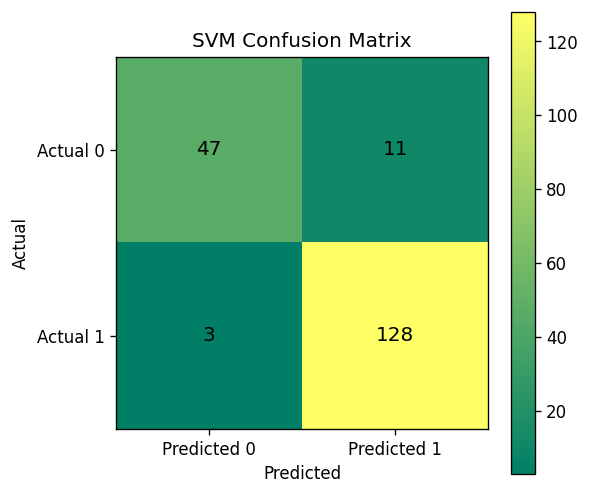

SVM Metrics: {'Accuracy': 0.926, 'Sensitivity (Recall)': 0.81, 'Specificity': 0.977, 'Precision': 0.94, 'F1-Score': 0.87}
Results saved to SVM_Results.csv
Results saved to SVM_Results_Final.csv


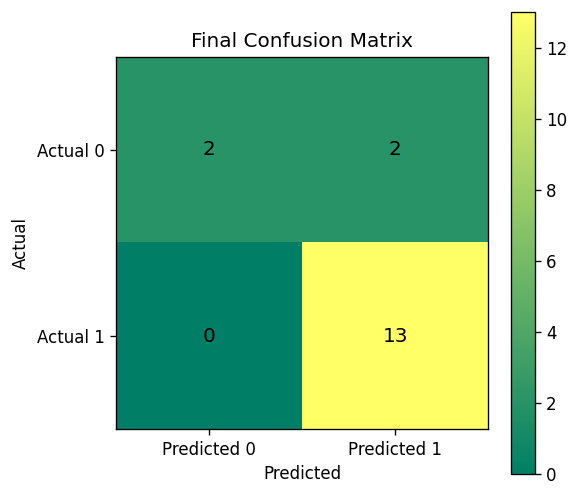

Final Metrics: {'Accuracy': 0.882, 'Sensitivity (Recall)': 0.5, 'Specificity': 1.0, 'Precision': 1.0, 'F1-Score': 0.667}


In [56]:
# 定義 SVM 模型
def train_svm(X_train, y_train, X_test, y_test, X_columns):
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'class_weight': ['balanced']
    }

    svm_grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    svm_grid_search.fit(X_train, y_train)

    best_model = svm_grid_search.best_estimator_
    best_params = svm_grid_search.best_params_
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(conf_matrix)

    # 如果使用線性核，可以直接通過 coef_ 計算特徵重要性
    if best_params['kernel'] == 'linear':
        feature_importance = np.abs(best_model.coef_[0])
        feature_importance_df = pd.DataFrame({
            'Feature': X_columns,
            'Importance': feature_importance
        }).sort_values(by='Importance', ascending=False)
    else:
        # 如果使用非線性核，則使用置換特徵重要性來估算
        results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        feature_importance = results.importances_mean  # 平均置換重要性得分
        feature_importance_df = pd.DataFrame({
            'Feature': X_columns,
            'Importance': feature_importance
        }).sort_values(by='Importance', ascending=False)

    # 預測測試集
    print("最佳參數:", best_params)
    print("特徵重要性排序：\n", feature_importance_df)

    return best_model, metrics, conf_matrix, y_pred, feature_importance_df


# SVM
svm_model, svm_metrics, svm_conf_matrix, svm_y_pred, feature_importance_df = train_svm(X_train, y_train, X_test, y_test, X.columns)
plot_confusion_matrix(svm_conf_matrix, title='SVM Confusion Matrix')
print("SVM Metrics:", svm_metrics)
save_results_to_csv('SVM_Results', info_test, y_test, svm_y_pred)

In [57]:
# 將每個 K 值的最佳準確率計算與繪圖封裝成函數
def plot_k_accuracy(knn_grid_search, param_grid):
    k_values = param_grid['n_neighbors']
    k_accuracy = {}

    for k in k_values:
        k_results = []
        for params, mean_score in zip(knn_grid_search.cv_results_['params'], 
                                      knn_grid_search.cv_results_['mean_test_score']):
            if params['n_neighbors'] == k:
                k_results.append((params, mean_score))
        best_k_params, best_k_score = max(k_results, key=lambda x: x[1]) if k_results else (None, 0)
        k_accuracy[k] = best_k_score

    plt.figure(figsize=(10, 6))
    plt.plot(list(k_accuracy.keys()), list(k_accuracy.values()), marker='o')
    plt.title('K Value Accuracy')
    plt.xlabel('K value')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.xticks(k_values)
    plt.show()

Fitting 5 folds for each of 44 candidates, totalling 220 fits


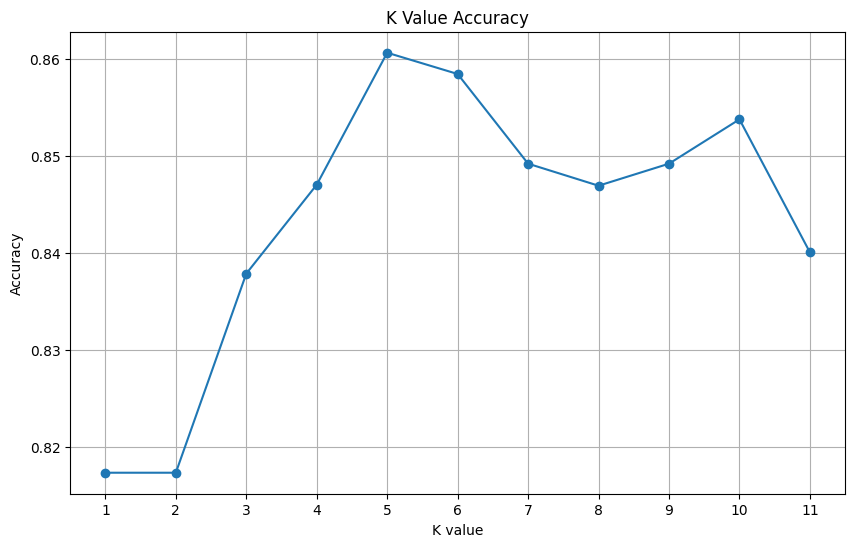

最佳參數: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
特徵重要性排序：
                  Feature  Importance
10              Ratio_BA    0.048148
11              Ratio_CA    0.031746
13          Ratio_BDCE_A    0.028042
3             Cycle Area    0.026984
0          systolic peak    0.022222
7                Delta_T    0.022222
9    1st Derivative peak    0.019048
2          Cardiac cycle    0.016931
4                    SSI    0.015344
8   1st Derivative cycle    0.013228
12              Ratio_DA    0.013228
5         Peak to Valley    0.009524
6        Systolic peak y    0.006878
14           Ratio_CDB_A    0.003704
1         Diastolic peak    0.002646


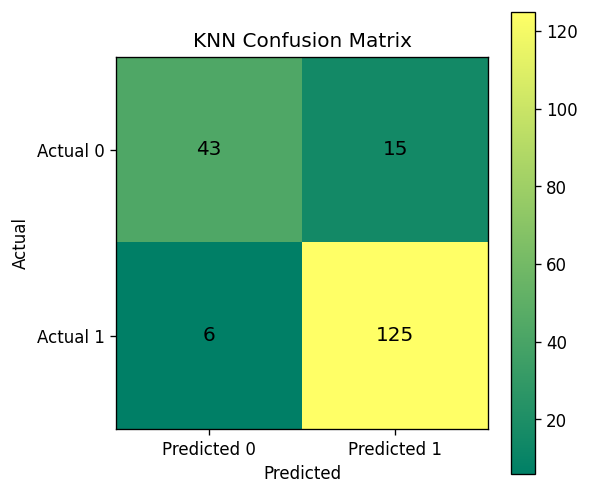

KNN Metrics: {'Accuracy': 0.889, 'Sensitivity (Recall)': 0.741, 'Specificity': 0.954, 'Precision': 0.878, 'F1-Score': 0.804}
Results saved to KNN_Results.csv
Results saved to KNN_Results_Final.csv


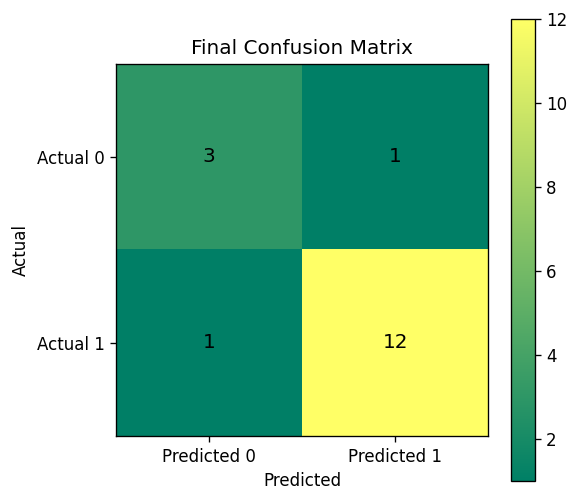

Final Metrics: {'Accuracy': 0.882, 'Sensitivity (Recall)': 0.75, 'Specificity': 0.923, 'Precision': 0.75, 'F1-Score': 0.75}


In [58]:
# 修改 KNN 模型訓練函數，以獲取每個 K 值的準確率
def train_knn(X_train, y_train, X_test, y_test):
    param_grid = {
        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }

    # 使用 GridSearchCV 找到最佳模型
    knn_grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    knn_grid_search.fit(X_train, y_train)

    best_model = knn_grid_search.best_estimator_
    best_params = knn_grid_search.best_params_
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(conf_matrix)


    plot_k_accuracy(knn_grid_search, param_grid)

    
    # 特徵重要性 - 基於置換的重要性
    results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    feature_importance = results.importances_mean  # 平均置換重要性得分
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    print("最佳參數:", best_params)
    print("特徵重要性排序：\n", feature_importance_df)



    

    return best_model, metrics, conf_matrix, y_pred, 

# KNN
knn_model, knn_metrics, knn_conf_matrix, knn_y_pred = train_knn(X_train, y_train, X_test, y_test)
plot_confusion_matrix(knn_conf_matrix, title='KNN Confusion Matrix')
print("KNN Metrics:", knn_metrics)
save_results_to_csv('KNN_Results', info_test, y_test, knn_y_pred)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
最佳參數: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 50}
特徵重要性排序：
                  Feature  Importance
10              Ratio_BA    0.162493
13          Ratio_BDCE_A    0.123235
11              Ratio_CA    0.105553
0          systolic peak    0.090952
5         Peak to Valley    0.090261
7                Delta_T    0.086786
1         Diastolic peak    0.061027
14           Ratio_CDB_A    0.045328
4                    SSI    0.043348
3             Cycle Area    0.041010
9    1st Derivative peak    0.036721
12              Ratio_DA    0.033578
6        Systolic peak y    0.028791
2          Cardiac cycle    0.026680
8   1st Derivative cycle    0.024237


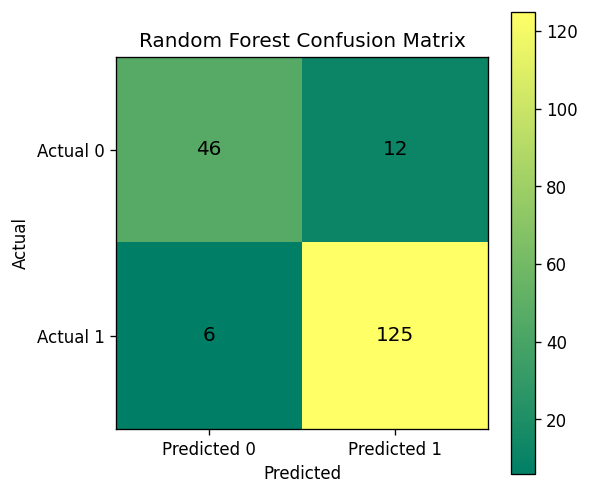

Random Forest Metrics: {'Accuracy': 0.905, 'Sensitivity (Recall)': 0.793, 'Specificity': 0.954, 'Precision': 0.885, 'F1-Score': 0.836}
Results saved to RF_Results.csv
Results saved to RF_Results_Final.csv


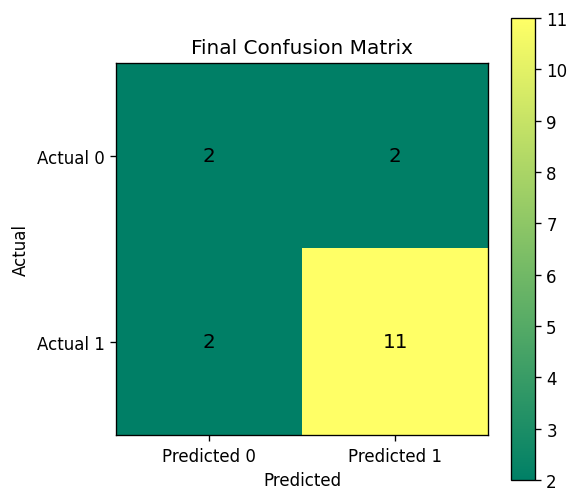

Final Metrics: {'Accuracy': 0.765, 'Sensitivity (Recall)': 0.5, 'Specificity': 0.846, 'Precision': 0.5, 'F1-Score': 0.5}


In [59]:
# 定義 Random Forest 模型
def train_rf(X_train, y_train, X_test, y_test):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced']
    }

    rf_grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    rf_grid_search.fit(X_train, y_train)

    best_model = rf_grid_search.best_estimator_
    best_params = rf_grid_search.best_params_
    y_pred = best_model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    metrics = calculate_metrics(conf_matrix)

        # 特徵重要性 - Random Forest 原生支援
    feature_importance = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    print("最佳參數:", best_params)
    print("特徵重要性排序：\n", feature_importance_df)
    
    return best_model, metrics, conf_matrix, y_pred

# Random Forest
rf_model, rf_metrics, rf_conf_matrix, rf_y_pred = train_rf(X_train, y_train, X_test, y_test)
plot_confusion_matrix(rf_conf_matrix, title='Random Forest Confusion Matrix')
print("Random Forest Metrics:", rf_metrics)
save_results_to_csv('RF_Results', info_test, y_test, rf_y_pred)
# 輸出結果
